# Marketing and Revenue Analytics

In [35]:
import pandas as pd

In [11]:
df = pd.read_excel(r'C:\Users\Asus\OneDrive\Desktop\Marketing and Revenue Analytics\Marketing&RevenueAnalytics_Project\online Retail Data.xlsx')

In [12]:
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [31]:
# Data Cleaning
df.dropna(subset = ['CustomerID'], inplace = True)

# Fiter out negative and zero Quantity and UnitPrices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert Invoice Date to DateTime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [33]:
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


# Customer Segmentation

In [55]:
# RFM Analysis: Calculate Recency, Frequency, and Monetary values for each customer.
import datetime as dt

ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

#Calculate the RFM Metrics
RFM = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'UnitPrice': 'sum'
}).rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo':'Frequency', 'UnitPrice': 'Monetary'})

In [57]:
print(RFM)

            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1      1.04
12347.0           2          7    481.21
12348.0          75          4    178.71
12349.0          19          1    605.10
12350.0         310          1     65.30
...             ...        ...       ...
18280.0         278          1     47.65
18281.0         181          1     39.36
18282.0           8          2     62.39
18283.0           4         16   1220.93
18287.0          43          3    104.55

[4338 rows x 3 columns]


# K-Means Clustering: Segment customers based on RFM scores

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [77]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(RFM)

kmeans = KMeans(n_clusters = 4, random_state = 42)
RFM['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [79]:
print(RFM.head())

            Recency  Frequency  Monetary  Cluster  AvgPurchaseValue  Tenure  \
CustomerID                                                                    
12346.0         326          1      1.04        1          1.040000     326   
12347.0           2          7    481.21        3         68.744286     367   
12348.0          75          4    178.71        3         44.677500     358   
12349.0          19          1    605.10        0        605.100000      19   
12350.0         310          1     65.30        1         65.300000     310   

            Churn  
CustomerID         
12346.0         1  
12347.0         0  
12348.0         0  
12349.0         0  
12350.0         1  


In [70]:
print(RFM['Cluster'])

CustomerID
12346.0    1
12347.0    0
12348.0    0
12349.0    0
12350.0    1
          ..
18280.0    1
18281.0    1
18282.0    0
18283.0    3
18287.0    0
Name: Cluster, Length: 4338, dtype: int32


# Churn Prediction

In [73]:
# Feature Engineering: Create features such as average purchase value, purchase frequency, and tenure.
# Calculate Additional Features
RFM['AvgPurchaseValue'] = RFM['Monetary']/RFM['Frequency']
RFM['Tenure'] = (ref_date - df.groupby('CustomerID')['InvoiceDate'].min()).dt.days

In [75]:
# Label Definition: Define churn based on a recency threshold.
# Define churn: Customers who haven't purchased in the last 90 days
RFM['Churn'] = (RFM['Recency'] > 90).astype(int)

In [81]:
# Model Training: Use Random Forest or XGBoost to predict churn.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and target
X = RFM[['Recency', 'Frequency', 'Monetary', 'AvgPurchaseValue', 'Tenure']]
y = RFM['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       865
           1       1.00      1.00      1.00       437

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302



# Revenue Forecasting

C:\Users\Asus\AppData\Local\Temp\ipykernel_15744\2350336666.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M', on = 'InvoiceDate')['Sales'].sum()


C:\Users\Asus\AppData\Local\Temp\ipykernel_15744\2350336666.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start = monthly_sales.index[-1], periods = 12, freq = 'M')


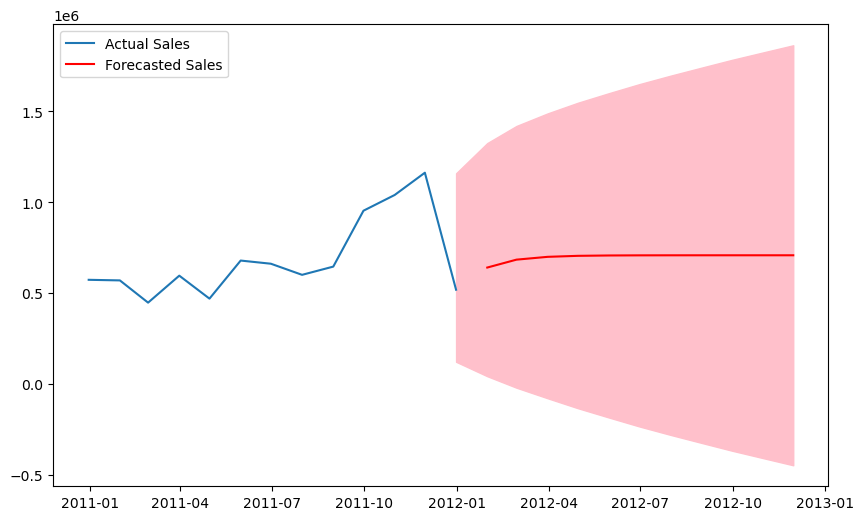

In [114]:
# Time Series Analysis: Aggregate sales data monthly and apply ARIMA or Prophet for forecasting.
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Aggregate Monthly sales
df['Sales'] = df['Quantity'] * df['UnitPrice']
monthly_sales = df.resample('M', on = 'InvoiceDate')['Sales'].sum()

# Fit ARIMA model
model = ARIMA(monthly_sales, order = (1,1,1))
print(model)
results = model.fit()

# Forecast
forecast = results.get_forecast(steps = 12)
forecast_index = pd.date_range(start = monthly_sales.index[-1], periods = 12, freq = 'M')
forecast_series = pd.Series(forecast.predicted_mean, index = forecast_index)

# Plot
plt.figure(figsize = (10,6))
plt.plot(monthly_sales, label = 'Actual Sales')
plt.plot(forecast_series, label = 'Forecasted Sales', color = 'red')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink')
plt.legend()
plt.show()

#  Price Elasticity & Promotional Impact

In [121]:
# Analysis: Examine how changes in price affect sales volume.
# Calculate Price Elasticity
import numpy as np
df['Revenue'] = df['Quantity'] * df['UnitPrice']
price_elasticity = df.groupby('StockCode').apply(lambda x:np.corrcoef(x['UnitPrice'],x['Quantity'])[0, 1]).rename('PriceElasticity')

C:\Users\Asus\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Asus\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Asus\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Asus\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Asus\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Asus\AppData\Local\Temp\ipykernel_15744\3307339204.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping 

# Customer Lifetime Value (CLV) Prediction

In [144]:
# CLV Calculation: Estimate future revenue from customers.
# Average purchase value
RFM['AvgPurchaseValue'] = RFM['Monetary'] / RFM['Frequency']

# Purchase frequency
purchase_frequency = RFM['Frequency']

In [146]:
print(purchase_frequency)

CustomerID
12346.0     1
12347.0     7
12348.0     4
12349.0     1
12350.0     1
           ..
18280.0     1
18281.0     1
18282.0     2
18283.0    16
18287.0     3
Name: Frequency, Length: 4338, dtype: int64
